# Multi-Class Image Classification Deep Learning Model for Weed Species Image Using TensorFlow Take 1
### David Lowe
### March 1, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Weed Species Image dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The Rock Paper Scissors dataset contains images from a variety of different hand poses with different races, ages, and genders. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real photos. All of this data is posed against a white background, and each image is 300×300 pixels in 24-bit color.]

ANALYSIS: The performance of the baseline model achieved an accuracy score of 100% after 15 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 82.26%. Furthermore, the final model processed the test dataset with an accuracy measurement of 82.26%.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Weed Species Image Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://github.com/AlexOlsen/DeepWeeds

One potential source of performance benchmarks: https://github.com/AlexOlsen/DeepWeeds

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [32]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [33]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Feb 21 21:50:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    37W / 300W |  15647MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [35]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [36]:
# Set the random seed number for reproducible results
seedNum = 888

In [37]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [38]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.GlorotUniform(seed=seedNum)
DEFAULT_EPOCH = 50
DEFAULT_BATCH = 32
DEFAULT_IMAGE_SIZE = (256, 256)
DEFAULT_IMAGE_SHAPE = (256, 256, 3)

NUM_CLASSES = 9
CLASS_LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
CLASS_NAMES = ['Chinee apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly acacia',
               'Rubber vine',
               'Siam weed',
               'Snake weed',
               'Negative']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [39]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [40]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [41]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [42]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [43]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [44]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [45]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm images.zip
!rm DeepWeeds-master.zip

In [46]:
!wget https://dainesanalytics.com/datasets/tensorflow-weed-species-image/DeepWeeds-master.zip

--2021-02-21 21:50:25--  https://dainesanalytics.com/datasets/tensorflow-weed-species-image/DeepWeeds-master.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.103.21, 13.225.103.13, 13.225.103.57, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.103.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547909 (535K) [application/zip]
Saving to: ‘DeepWeeds-master.zip’

DeepWeeds-master.zi 100%[===================>] 535.07K  --.-KB/s    in 0.06s   

2021-02-21 21:50:25 (9.46 MB/s) - ‘DeepWeeds-master.zip’ saved [547909/547909]



In [47]:
!wget https://dainesanalytics.com/datasets/tensorflow-weed-species-image/images.zip

--2021-02-21 21:50:25--  https://dainesanalytics.com/datasets/tensorflow-weed-species-image/images.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.103.21, 13.225.103.13, 13.225.103.57, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.103.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491516047 (469M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 468.75M   199MB/s    in 2.4s    

2021-02-21 21:50:28 (199 MB/s) - ‘images.zip’ saved [491516047/491516047]



In [48]:
staging_dir = 'staging/'
!mkdir staging/
!mkdir staging/images/

In [49]:
# Unzip and put the files into the staging folder
local_zip = 'DeepWeeds-master.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
local_zip = 'images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir+'images/')
zip_ref.close()

In [50]:
data_dir = 'staging/images/'
labels_dir = 'staging/DeepWeeds-master/labels/'

In [51]:
train_dataframe = pd.read_csv(labels_dir+'labels.csv')
train_dataframe['Label'] = train_dataframe['Label'].astype(str)
print(train_dataframe.head())

                Filename Label       Species
0  20160928-140314-0.jpg     0  Chinee apple
1  20160928-140337-0.jpg     0  Chinee apple
2  20160928-140731-0.jpg     0  Chinee apple
3  20160928-140747-0.jpg     0  Chinee apple
4  20160928-141107-0.jpg     0  Chinee apple


In [52]:
print(train_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17509 entries, 0 to 17508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  17509 non-null  object
 1   Label     17509 non-null  object
 2   Species   17509 non-null  object
dtypes: object(3)
memory usage: 410.5+ KB
None


In [53]:
# Brief listing of training image files for each class
for c_name in CLASS_NAMES:
    training_class_files = train_dataframe[train_dataframe['Species']==c_name]
    print('Number of training images for', c_name, ':', len(training_class_files))
    print('Training samples for', c_name, ':\n', training_class_files[:5], '\n')

Number of training images for Chinee apple : 1125
Training samples for Chinee apple :
                 Filename Label       Species
0  20160928-140314-0.jpg     0  Chinee apple
1  20160928-140337-0.jpg     0  Chinee apple
2  20160928-140731-0.jpg     0  Chinee apple
3  20160928-140747-0.jpg     0  Chinee apple
4  20160928-141107-0.jpg     0  Chinee apple 

Number of training images for Lantana : 1064
Training samples for Lantana :
                  Filename Label  Species
50  20161207-112141-0.jpg     1  Lantana
59  20161207-142354-0.jpg     1  Lantana
60  20161207-142413-0.jpg     1  Lantana
76  20170126-095106-0.jpg     1  Lantana
77  20170126-095120-0.jpg     1  Lantana 

Number of training images for Parkinsonia : 1031
Training samples for Parkinsonia :
                    Filename Label      Species
5202  20170920-093829-1.jpg     2  Parkinsonia
5203  20170920-093850-1.jpg     2  Parkinsonia
5204  20170920-093909-1.jpg     2  Parkinsonia
5207  20170920-094037-2.jpg     2  Parkinso

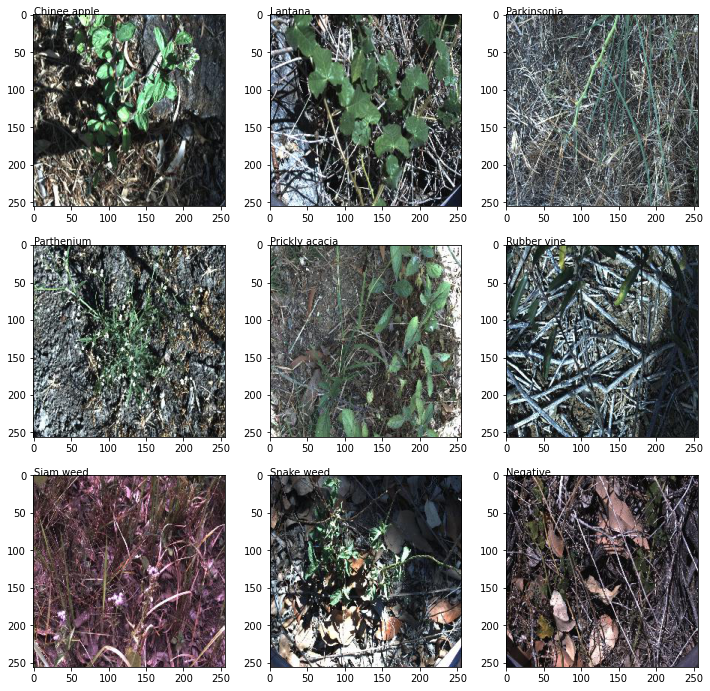

In [54]:
# Plot some training images from the dataset
nrows = 3
ncols = 3
training_examples = []

for c_name in CLASS_NAMES:
    training_class_files = train_dataframe[train_dataframe['Species']==c_name]
    training_examples.append(training_class_files.at[training_class_files.index[0],'Filename'])

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.text(0, 0, CLASS_NAMES[i])
    # sp.axis('Off')
    img = mpimg.imread(data_dir + img_path)
    plt.imshow(img)
plt.show()

In [55]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_SIZE)
dataflow_kwargs = dict(target_size=DEFAULT_IMAGE_SIZE, batch_size=DEFAULT_BATCH, classes=CLASS_LABELS, class_mode='categorical')

print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(**datagen_kwargs)
validation_generator = validation_datagen.flow_from_dataframe(train_dataframe,
                                                              directory=data_dir,
                                                              x_col='Filename',
                                                              y_col='Label',
                                                              subset="validation",
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(fill_mode="constant",
                                          shear_range=0.2,
                                          zoom_range=(0.5, 1),
                                          horizontal_flip=True,
                                          rotation_range=360,
                                          channel_shift_range=25,
                                          brightness_range=(0.75, 1.25),
                                          **datagen_kwargs)
else:
    training_datagen = validation_datagen

print('\nLoading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(train_dataframe,
                                                          directory=data_dir,
                                                          x_col='Filename',
                                                          y_col='Label',
                                                          subset="training",
                                                          shuffle=True,
                                                          seed=seedNum,
                                                          **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the validation images...
Found 3501 validated image filenames belonging to 9 classes.
Number of image batches per epoch of modeling: 110

Loading and pre-processing the training images...
Found 14008 validated image filenames belonging to 9 classes.
Number of image batches per epoch of modeling: 438


In [56]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [57]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [58]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [59]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=DEFAULT_IMAGE_SHAPE, output_param=NUM_CLASSES, loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.applications.VGG16(include_top=True, weights=None, input_shape=input_param, classes=output_param)
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [60]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=DEFAULT_EPOCH,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/25
438/438 [==============================] - 87s 195ms/step - loss: 1.3457 - accuracy: 0.6117 - val_loss: 4.7664 - val_accuracy: 0.1043
Epoch 2/25
438/438 [==============================] - 85s 194ms/step - loss: 1.1006 - accuracy: 0.6372 - val_loss: 4.9739 - val_accuracy: 0.1031
Epoch 3/25
438/438 [==============================] - 85s 193ms/step - loss: 1.0825 - accuracy: 0.6353 - val_loss: 4.5452 - val_accuracy: 0.1063
Epoch 4/25
438/438 [==============================] - 84s 193ms/step - loss: 0.9691 - accuracy: 0.6494 - val_loss: 4.8323 - val_accuracy: 0.0914
Epoch 5/25
438/438 [==============================] - 85s 193ms/step - loss: 0.8874 - accuracy: 0.6722 - val_loss: 4.7489 - val_accuracy: 0.0877

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/25
438/438 [==============================] - 85s 193ms/step - loss: 0.7580 - accuracy: 0.7140 - val_loss: 5.0858 - val_accuracy: 0.0851
Epoch 7/25
438/438 [=============================

In [61]:
nn_model_0.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

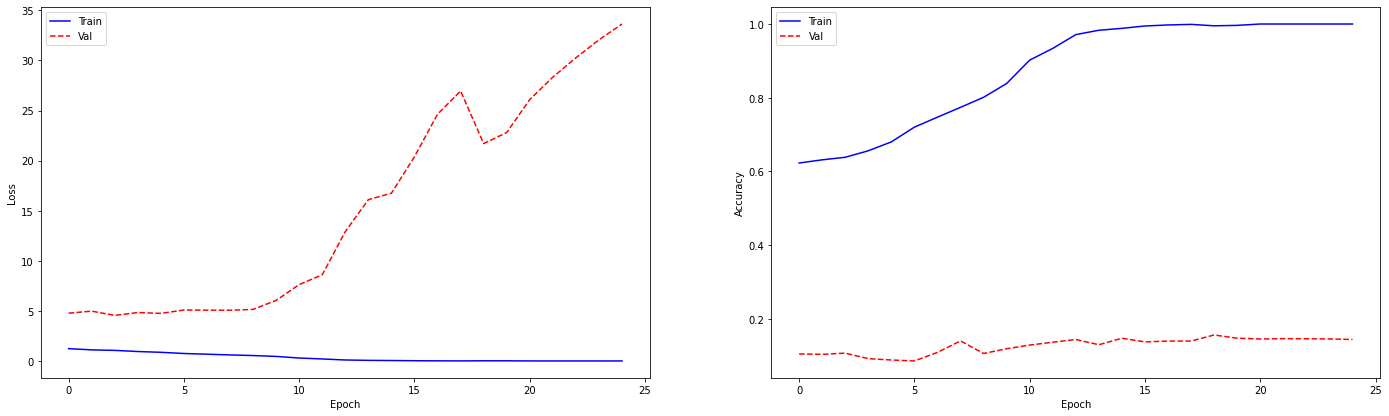

In [62]:
plot_metrics(nn_model_history)

In [63]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [64]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [65]:
# Not applicable for this iteration of modeling

In [66]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [67]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [68]:
# datagen_kwargs = dict(rescale=1./255)
# dataflow_kwargs = dict(target_size=DEFAULT_IMAGE_SIZE, batch_size=DEFAULT_BATCH, classes=CLASS_LABELS, class_mode='categorical')

# print('Loading and pre-processing the training images...')
# training_generator = training_datagen.flow_from_dataframe(train_dataframe,
#                                                           directory=data_dir,
#                                                           x_col='Filename',
#                                                           y_col='Label',
#                                                           subset="training",
#                                                           shuffle=True,
#                                                           seed=seedNum,
#                                                           **dataflow_kwargs)
# print('Number of image batches per epoch of modeling:', len(training_generator))

In [69]:
# # Train the final model with the entire collection of images
# FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.000006)
# final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
# final_model.fit(
#     training_generator,
#     steps_per_epoch=len(training_generator),
#     epochs=DEFAULT_EPOCH,
#     verbose=1)
# print('Total time for model fitting:', (datetime.now() - startTimeModule))

In [70]:
# # Display a summary of the final model
# final_model.summary()

In [71]:
# # Print the labels used for the modeling
# print(validation_generator.class_indices)

In [72]:
# final_model.evaluate(validation_generator, verbose=1)

In [73]:
# # Make batched predictions
# test_pred = final_model.predict(validation_generator)
# test_predictions = np.argmax(test_pred, axis=-1)
# test_original = validation_generator.labels
# print('Accuracy Score:', accuracy_score(test_original, test_predictions))
# print(confusion_matrix(test_original, test_predictions))
# print(classification_report(test_original, test_predictions))

In [74]:
# # Make a signle prediction
# flower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# flower_path = keras.utils.get_file('Red_sunflower', origin=flower_url)

# img = keras.preprocessing.image.load_img(flower_path, target_size=DEFAULT_IMAGE_SIZE)
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = final_model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print("This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [75]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [76]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:35:31.277768
